In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn
import cv2
import torch

from PIL import Image
from tqdm import tqdm

In [2]:
%%writefile dataset.py

import glob
import cv2
import numpy as np
import scipy.io as sio


class __AbstractDataset(object):
    """Abstract class for interface of subsequent classes.
    Main idea is to encapsulate how each dataset should parse
    their images and annotations.
    
    """

    def load_img(self, path):
        raise NotImplementedError

    def load_ann(self, path, with_type=False):
        raise NotImplementedError


####
class __PanNuke(__AbstractDataset):

    def load_img(self, path):
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    def load_ann(self, path, with_type=False):
        # assumes that ann is HxW
        assert not with_type, "Not support"
        ann_inst = sio.loadmat(path)["inst_map"]
        ann_inst = ann_inst.astype("int32")
        ann = np.expand_dims(ann_inst, -1)
        return ann


####
def get_dataset(name):
    """Return a pre-defined dataset object associated with `name`."""
    name_dict = {
        "pannuke": lambda: __PanNuke(),
    }
    if name.lower() in name_dict:
        return name_dict[name]()
    else:
        assert False, "Unknown dataset `%s`" % name

Overwriting dataset.py


In [3]:
%%writefile config.py

import importlib
import random

import cv2
import numpy as np

from dataset import get_dataset


class Config(object):
    """Configuration file."""

    def __init__(self):
        self.seed = 10

        self.logging = True

        # turn on debug flag to trace some parallel processing problems more easily
        self.debug = False

        model_name = "hovernet"
        model_mode = "fast" # choose either `original` or `fast`

        if model_mode not in ["original", "fast"]:
            raise Exception("Must use either `original` or `fast` as model mode")

        nr_type = 6 # number of nuclear types (including background)
        self.type_classification = True

        # shape information - 
        # below config is for original mode. 
        # If original model mode is used, use [270,270] and [80,80] for act_shape and out_shape respectively
        # If fast model mode is used, use [256,256] and [164,164] for act_shape and out_shape respectively
        aug_shape = [540, 540] # patch shape used during augmentation (larger patch may have less border artefacts)
        act_shape = [256,256] # patch shape used as input to network - central crop performed after augmentation
        out_shape = [164,164] # patch shape at output of network

        if model_mode == "original":
            if act_shape != [270,270] or out_shape != [80,80]:
                raise Exception("If using `original` mode, input shape must be [270,270] and output shape must be [80,80]")
        if model_mode == "fast":
            if act_shape != [256,256] or out_shape != [164,164]:
                raise Exception("If using `fast` mode, input shape must be [256,256] and output shape must be [164,164]")

        self.dataset_name = "pannuke" # extracts dataset info from dataset.py
        self.log_dir = "checkpoint/" # where checkpoints will be saved

        # paths to training and validation patches
        self.train_dir_list = [
            "train/"
        ]
        self.valid_dir_list = [
            "val/"
        ]

        self.shape_info = {
            "train": {"input_shape": act_shape, "mask_shape": out_shape,},
            "valid": {"input_shape": act_shape, "mask_shape": out_shape,},
        }

        # * parsing config to the running state and set up associated variables
        self.dataset = get_dataset(self.dataset_name)

        module = importlib.import_module(
            "models.%s.opt" % model_name
        )
        self.model_config = module.get_config(nr_type, model_mode)

Overwriting config.py


In [5]:
%%writefile hover_net/models/hovernet/opt.py

import torch.optim as optim

from run_utils.callbacks.base import (
    AccumulateRawOutput,
    PeriodicSaver,
    ProcessAccumulatedRawOutput,
    ScalarMovingAverage,
    ScheduleLr,
    TrackLr,
    VisualizeOutput,
    TriggerEngine,
)
from run_utils.callbacks.logging import LoggingEpochOutput, LoggingGradient
from run_utils.engine import Events

from .targets import gen_targets, prep_sample
from .net_desc import create_model
from .run_desc import proc_valid_step_output, train_step, valid_step, viz_step_output


# TODO: training config only ?
# TODO: switch all to function name String for all option
def get_config(nr_type, mode):
    return {
        # ------------------------------------------------------------------
        # ! All phases have the same number of run engine
        # phases are run sequentially from index 0 to N
        "phase_list": [
            {
                "run_info": {
                    # may need more dynamic for each network
                    "net": {
                        "desc": lambda: create_model(
                            input_ch=3, nr_types=nr_type, 
                            freeze=True, mode=mode
                        ),
                        "optimizer": [
                            optim.Adam,
                            {  # should match keyword for parameters within the optimizer
                                "lr": 0.0025,  # initial learning rate,
                                "betas": (0.9, 0.999),
                            },
                        ],
                        # learning rate scheduler
                        "lr_scheduler": lambda x: optim.lr_scheduler.MultiStepLR(x, milestones=[8,11]),
                        "extra_info": {
                            "loss": {
                                "np": {"bce": 1, "dice": 1},
                                "hv": {"mse": 1, "msge": 1},
                                "tp": {"bce": 1, "dice": 1},
                            },
                        },
                        # path to load, -1 to auto load checkpoint from previous phase,
                        # None to start from scratch
                        "pretrained": "../../input/preactresnet50-weights/ImageNet-ResNet50-Preact_pytorch.tar",
                        # 'pretrained': None,
                    },
                },
                "target_info": {"gen": (gen_targets, {}), "viz": (prep_sample, {})},
                "batch_size": {"train": 2, "valid": 2,},  # engine name : value
                "nr_epochs": 12,
            },
            {
                "run_info": {
                    # may need more dynamic for each network
                    "net": {
                        "desc": lambda: create_model(
                            input_ch=3, nr_types=nr_type, 
                            freeze=False, mode=mode
                        ),
                        "optimizer": [
                            optim.Adam,
                            {  # should match keyword for parameters within the optimizer
                                "lr": 0.0025,  # initial learning rate,
                                "betas": (0.9, 0.999),
                            },
                        ],
                        # learning rate scheduler
                        "lr_scheduler": lambda x: optim.lr_scheduler.MultiStepLR(x, milestones=[8,11]),
                        "extra_info": {
                            "loss": {
                                "np": {"bce": 1, "dice": 1},
                                "hv": {"mse": 1, "msge": 1},
                                "tp": {"bce": 1, "dice": 1},
                            },
                        },
                        # path to load, -1 to auto load checkpoint from previous phase,
                        # None to start from scratch
                        "pretrained": -1,
                    },
                },
                "target_info": {"gen": (gen_targets, {}), "viz": (prep_sample, {})},
                "batch_size": {"train": 2, "valid": 2,}, # batch size per gpu
                "nr_epochs": 12,
            },
        ],
        # ------------------------------------------------------------------
        # TODO: dynamically for dataset plugin selection and processing also?
        # all enclosed engine shares the same neural networks
        # as the on at the outer calling it
        "run_engine": {
            "train": {
                # TODO: align here, file path or what? what about CV?
                "dataset": "",  # whats about compound dataset ?
                "nr_procs": 16,  # number of threads for dataloader
                "run_step": train_step,  # TODO: function name or function variable ?
                "reset_per_run": False,
                # callbacks are run according to the list order of the event
                "callbacks": {
                    Events.STEP_COMPLETED: [
                        # LoggingGradient(), # TODO: very slow, may be due to back forth of tensor/numpy ?
                        ScalarMovingAverage(),
                    ],
                    Events.EPOCH_COMPLETED: [
                        TrackLr(),
                        PeriodicSaver(),
                        VisualizeOutput(viz_step_output),
                        LoggingEpochOutput(),
                        TriggerEngine("valid"),
                        ScheduleLr(),
                    ],
                },
            },
            "valid": {
                "dataset": "",  # whats about compound dataset ?
                "nr_procs": 8,  # number of threads for dataloader
                "run_step": valid_step,
                "reset_per_run": True,  # * to stop aggregating output etc. from last run
                # callbacks are run according to the list order of the event
                "callbacks": {
                    Events.STEP_COMPLETED: [AccumulateRawOutput(),],
                    Events.EPOCH_COMPLETED: [
                        # TODO: is there way to preload these ?
                        ProcessAccumulatedRawOutput(
                            lambda a: proc_valid_step_output(a, nr_types=nr_type)
                        ),
                        LoggingEpochOutput(),
                    ],
                },
            },
        },
    }

Overwriting hover_net/models/hovernet/opt.py


In [6]:
%%writefile hover_net/models/hovernet/targets.py

import math
import numpy as np

import torch
import torch.nn.functional as F

from scipy import ndimage
from scipy.ndimage import measurements
from skimage import morphology as morph
import matplotlib.pyplot as plt

from misc.utils import center_pad_to_shape, cropping_center, get_bounding_box
from dataloader.augs import fix_mirror_padding


####
def gen_instance_hv_map(ann, crop_shape):
    """Input annotation must be of original shape.
    
    The map is calculated only for instances within the crop portion
    but based on the original shape in original image.

    Perform following operation:
    Obtain the horizontal and vertical distance maps for each
    nuclear instance.

    """
    orig_ann = ann.copy()  # instance ID map
    fixed_ann = fix_mirror_padding(orig_ann)
    # re-cropping with fixed instance id map
    crop_ann = cropping_center(fixed_ann, crop_shape)
    # TODO: deal with 1 label warning
    crop_ann = morph.remove_small_objects(crop_ann, min_size=30)

    x_map = np.zeros(orig_ann.shape[:2], dtype=np.float32)
    y_map = np.zeros(orig_ann.shape[:2], dtype=np.float32)

    inst_list = list(np.unique(crop_ann))
    inst_list.remove(0)  # 0 is background
    for inst_id in inst_list:
        inst_map = np.array(fixed_ann == inst_id, np.uint8)
        inst_box = get_bounding_box(inst_map)

        # expand the box by 2px
        # Because we first pad the ann at line 207, the bboxes
        # will remain valid after expansion
        inst_box[0] -= 2
        inst_box[2] -= 2
        inst_box[1] += 2
        inst_box[3] += 2

        inst_map = inst_map[inst_box[0] : inst_box[1], inst_box[2] : inst_box[3]]

        if inst_map.shape[0] < 2 or inst_map.shape[1] < 2:
            continue

        # instance center of mass, rounded to nearest pixel
        inst_com = list(measurements.center_of_mass(inst_map))

        inst_com[0] = int(inst_com[0] + 0.5)
        inst_com[1] = int(inst_com[1] + 0.5)

        inst_x_range = np.arange(1, inst_map.shape[1] + 1)
        inst_y_range = np.arange(1, inst_map.shape[0] + 1)
        # shifting center of pixels grid to instance center of mass
        inst_x_range -= inst_com[1]
        inst_y_range -= inst_com[0]

        inst_x, inst_y = np.meshgrid(inst_x_range, inst_y_range)

        # remove coord outside of instance
        inst_x[inst_map == 0] = 0
        inst_y[inst_map == 0] = 0
        inst_x = inst_x.astype("float32")
        inst_y = inst_y.astype("float32")

        # normalize min into -1 scale
        if np.min(inst_x) < 0:
            inst_x[inst_x < 0] /= -np.amin(inst_x[inst_x < 0])
        if np.min(inst_y) < 0:
            inst_y[inst_y < 0] /= -np.amin(inst_y[inst_y < 0])
        # normalize max into +1 scale
        if np.max(inst_x) > 0:
            inst_x[inst_x > 0] /= np.amax(inst_x[inst_x > 0])
        if np.max(inst_y) > 0:
            inst_y[inst_y > 0] /= np.amax(inst_y[inst_y > 0])

        ####
        x_map_box = x_map[inst_box[0] : inst_box[1], inst_box[2] : inst_box[3]]
        x_map_box[inst_map > 0] = inst_x[inst_map > 0]

        y_map_box = y_map[inst_box[0] : inst_box[1], inst_box[2] : inst_box[3]]
        y_map_box[inst_map > 0] = inst_y[inst_map > 0]

    hv_map = np.dstack([x_map, y_map])
    return hv_map


####
def gen_targets(ann, crop_shape, **kwargs):
    """Generate the targets for the network."""
    hv_map = gen_instance_hv_map(ann, crop_shape)
    np_map = ann.copy()
    np_map[np_map > 0] = 1

    hv_map = cropping_center(hv_map, crop_shape)
    np_map = cropping_center(np_map, crop_shape)

    target_dict = {
        "hv_map": hv_map,
        "np_map": np_map,
    }

    return target_dict


####
def prep_sample(data, is_batch=False, **kwargs):
    """
    Designed to process direct output from loader
    """
    cmap = plt.get_cmap("jet")

    def colorize(ch, vmin, vmax, shape):
        ch = np.squeeze(ch.astype("float32"))
        ch = ch / (vmax - vmin + 1.0e-16)
        # take RGB from RGBA heat map
        ch_cmap = (cmap(ch)[..., :3] * 255).astype("uint8")
        ch_cmap = center_pad_to_shape(ch_cmap, shape)
        return ch_cmap

    def prep_one_sample(data):
        shape_array = [np.array(v.shape[:2]) for v in data.values()]
        
#         for v in data.values():
#             print(np.array(v.shape[:2]))
#             raise ValueError("debugging")
#         print(shape_array)
#         print(max(shape_array, key=lambda x:np.max(x)))
#         raise ValueError("debugging")
        
        shape = max(shape_array, key=lambda x:np.max(x))
        viz_list = []
        viz_list.append(colorize(data["np_map"], 0, 1, shape))
        # map to [0,2] for better visualisation.
        # Note, [-1,1] is used for training.
        viz_list.append(colorize(data["hv_map"][..., 0] + 1, 0, 2, shape))
        viz_list.append(colorize(data["hv_map"][..., 1] + 1, 0, 2, shape))
        img = center_pad_to_shape(data["img"], shape)
        return np.concatenate([img] + viz_list, axis=1)

    # cmap may randomly fails if of other types
    if is_batch:
        viz_list = []
        data_shape = list(data.values())[0].shape
        for batch_idx in range(data_shape[0]):
            sub_data = {k : v[batch_idx] for k, v in data.items()}
            viz_list.append(prep_one_sample(sub_data))
        return np.concatenate(viz_list, axis=0)
    else:
        return prep_one_sample(data)

Overwriting hover_net/models/hovernet/targets.py


In [8]:
import os
print(os.getcwd())


/mnt/storage1/Hover-Net


In [7]:
if not os.path.isdir('../hover-net'):
    os.mkdir('../hover-net/')
    os.mkdir('../hover-net/infer_tiles/')
    os.mkdir('../hover-net/infer_tiles/imgs/')
    os.mkdir('../hover-net/infer_tiles/pred/')

In [1]:
!cp -r /mnt/storage1/Hover-Net/hover_net/checkpoint .././hover-net

In [2]:
!cp -r /mnt/storage1/Hover-Net/images/101.jpeg .././hover-net/infer_tiles/imgs/
!cp -r /mnt/storage1/Hover-Net/images/105.jpeg .././hover-net/infer_tiles/imgs/
!cp -r /mnt/storage1/Hover-Net/images/106.jpeg .././hover-net/infer_tiles/imgs/
!cp -r /mnt/storage1/Hover-Net/images/1003.jpeg .././hover-net/infer_tiles/imgs/
!cp -r /mnt/storage1/Hover-Net/images/1037.jpeg .././hover-net/infer_tiles/imgs/
!cp -r /mnt/storage1/Hover-Net/images/1056.jpeg .././hover-net/infer_tiles/imgs/

In [5]:
!python /mnt/storage1/Hover-Net/hover_net/run_infer.py \
--gpu='0' \
--nr_types=6 \
--type_info_path=/mnt/storage1/Hover-Net/hover_net/type_info.json \
--batch_size=1 \
--model_mode=fast \
--model_path=../hover-net/checkpoint/01/net_epoch=12.tar \
--nr_inference_workers=1 \
--nr_post_proc_workers=1 \
tile \
--input_dir=../hover-net/infer_tiles/imgs/ \
--output_dir=../hover-net/infer_tiles/pred/ \
--mem_usage=0.1 \
--draw_dot \
--save_qupath

|2024-08-23|23:13:24.508| [INFO] .... Detect #GPUS: 1
Process Patches:  96%|########################9 | 24/25 [00:03<00:00,  6.62it/s]
|2024-08-23|23:13:33.678| [INFO] ........................ Done Assembling 1003
|2024-08-23|23:13:33.685| [INFO] ........................ Done Assembling 101
|2024-08-23|23:13:33.691| [INFO] ........................ Done Assembling 1037
|2024-08-23|23:13:33.697| [INFO] ........................ Done Assembling 105
|2024-08-23|23:13:33.704| [INFO] ........................ Done Assembling 1056
|2024-08-23|23:13:33.712| [INFO] ........................ Done Assembling 106


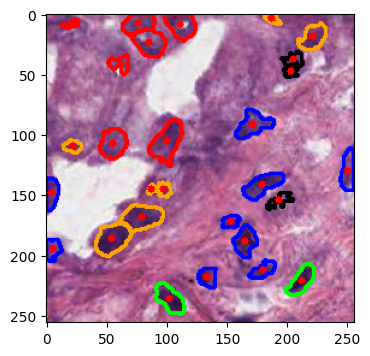

In [8]:

import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('../hover-net/infer_tiles/pred/overlay/1056.png')

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(4,4))
plt.imshow(img)

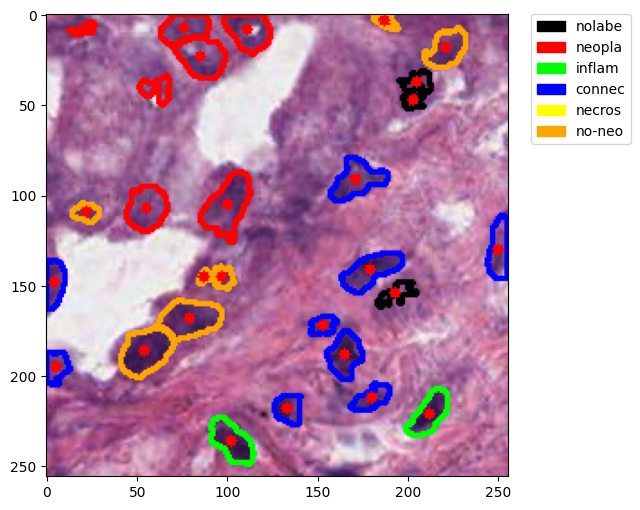

In [9]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the image
img = cv2.imread('../hover-net/infer_tiles/pred/overlay/1037.png')

# Convert the image to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create a figure and axis
plt.figure(figsize=(6, 6))
plt.imshow(img)

# Create a legend based on the type_info_dict
type_info_dict = {
    0: ("nolabe", (0, 0, 0)),        # no label
    1: ("neopla", (255, 0, 0)),      # neoplastic
    2: ("inflam", (0, 255, 0)),      # inflamm
    3: ("connec", (0, 0, 255)),      # connective
    4: ("necros", (255, 255, 0)),    # dead
    5: ("no-neo", (255, 165, 0))     # non-neoplastic epithelial
}

# Create patches for each label
patches = [mpatches.Patch(color=[v/255 for v in color], label=label) 
           for label, color in type_info_dict.values()]

# Add the legend to the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Save the figure
plt.savefig('image_with_legend.png', bbox_inches='tight')

# Optionally, you can display the plot
plt.show()
